In [1]:
import os
import ahpy
import json
import math
import random
import hashlib
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd
import rioxarray as rxr
import matplotlib.pyplot as plt

from utils import Infiltrometro, ALL_FUNCTIONS, nse, points_distance, USO_SOLO_CLASS, SOIL_TYPES

from tqdm import tqdm
from xgboost import XGBRegressor
from shapely.geometry import Point
from scipy.optimize import curve_fit
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from itertools import combinations, product, islice
from sklearn.metrics import root_mean_squared_error
from sklearn.preprocessing import QuantileTransformer

In [2]:
OBS = rxr.open_rasterio(r"D:\Mestrado\Trabalho Final\SIG\ClassificacaoCondutividadeHidraulica.tif") # Raster com dados classificados pela condutividade
AHP = rxr.open_rasterio(r"D:\Mestrado\Trabalho Final\SIG\Classificacao_Infiltracao_AHP_2.tif")      # Raster com dados classificados pelo método AHP
MIF = rxr.open_rasterio(r"D:\Mestrado\Trabalho Final\SIG\Classificacao_Infiltracao_MIF_2.tif")      # Raster com dados classificados pelo método MIF
AD  = gpd.read_file(r"D:\Mestrado\Trabalho Final\SIG\AreaDrenagemIbirite.zip")                      # Shape com a área toda

In [3]:
layers = ["AD", "Urubu", "Taboão", "Sumidouro", "Rola Moça", "Pintado", "Jatobá", "Fubá", "Barreirinho"]

rasters = {
    "OBS": OBS,
    "AHP": AHP,
    "MIF": MIF,
}

In [4]:
def save_raster(data:np.ndarray, file:str):
    raster = xr.DataArray(
        data.astype("float32"),
        dims=("y", "x"),
        coords={"x": condutividade.x, "y": condutividade.y},
        name=f"class_condutividade_hidro"
    )

    # Copiar CRS e transformar em um raster compatível
    raster = raster.rio.write_crs(condutividade.rio.crs)
    raster = raster.rio.reproject_match(condutividade)

    # (opcional) definir valor nodata
    raster = raster.rio.write_nodata(-9999)

    # Salvar como GeoTIFF
    raster.rio.to_raster(file)

In [10]:
data = {
    "OBS": [],
    "AHP": [],
    "MIF": [],
    "geometry": [],
}

for layer in layers:
    if layer == "AD":
        gdf = AD
    else:
        gdf = gpd.read_file(r"D:\Mestrado\Trabalho Final\SIG\subbacias2.gpkg", layer = layer)
    
    gdf_geom = gdf.to_crs("EPSG:31983").copy()
    geom = gdf_geom.geometry.values.union_all()
    data["geometry"].append(geom)
    
    for name, rast in tqdm(rasters.items(), desc=f"{layer} - Raster", total=len(rasters)):

        # Clipando o raster:
        clipped = rast.rio.clip([geom], drop=True)

        arr = clipped.squeeze().values
        arr = arr[(~np.isnan(arr)) & (arr >= 0)]

        mean   = np.mean(arr)
        median = np.median(arr)
        min    = np.min(arr)
        max    = np.max(arr)

        data[name].append({
            "subbacia": layer,
            "mean": mean,
            "median":median,
            "min": min,
            "max": max,
        })

for tipo in tqdm(["OBS", "AHP", "MIF"], desc="Salvando", total=3):
    gdf = gpd.GeoDataFrame(data[tipo], geometry=data["geometry"], crs="EPSG:31983")
    gdf.to_file(r"D:\Mestrado\Trabalho Final\SIG\subbacias.gpkg", layer = tipo)

Salvando: 100%|██████████| 3/3 [00:08<00:00,  2.89s/it]


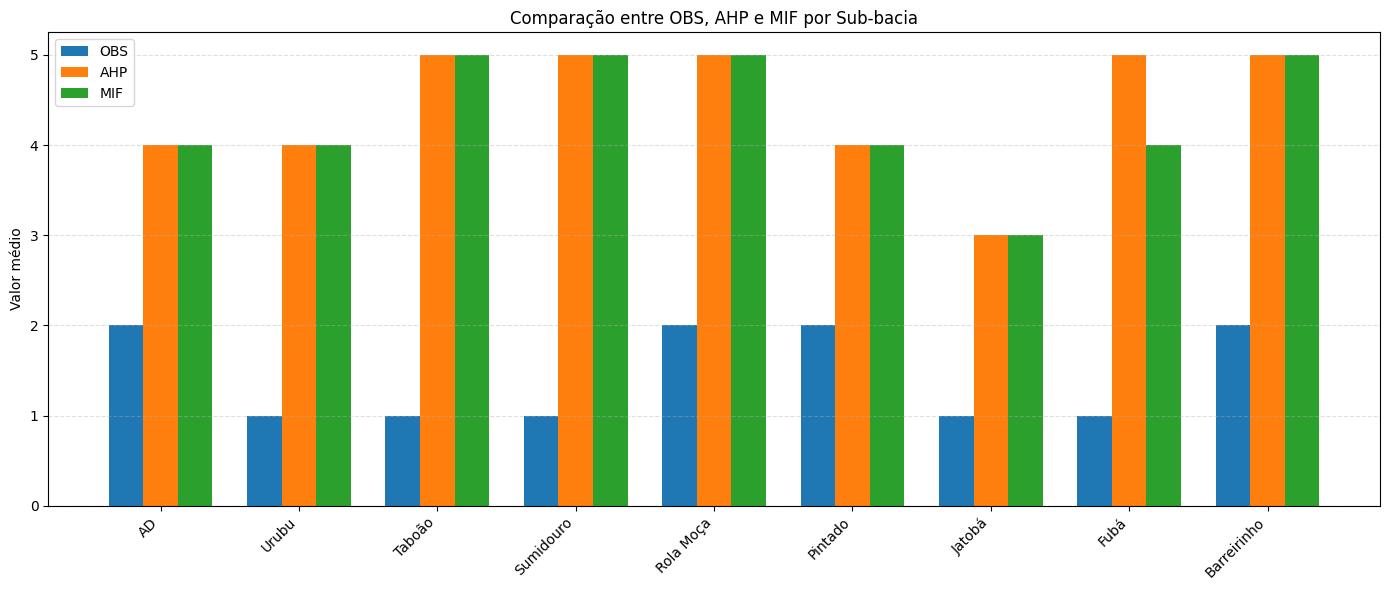

In [6]:
# Converter seu dicionário em DataFrame
df = pd.DataFrame(data)
df = df.reindex(layers)

# Número de grupos (sub-bacias)
n = len(df)

# Número de categorias (OBS, AHP, MIF)
k = df.shape[1]

# Largura de cada barra
width = 0.25

# Posições no eixo X
x = np.arange(n)

# Criar gráfico
plt.figure(figsize=(14, 6))

# Plotar cada coluna deslocada no eixo X
plt.bar(x - width, df["OBS"], width, label="OBS", color="#1f77b4")
plt.bar(x,         df["AHP"], width, label="AHP", color="#ff7f0e")
plt.bar(x + width, df["MIF"], width, label="MIF", color="#2ca02c")

# Ajustes visuais
plt.xticks(x, df.index, rotation=45, ha="right")
plt.ylabel("Valor médio")
plt.title("Comparação entre OBS, AHP e MIF por Sub-bacia")
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.legend()

plt.tight_layout()
plt.show()
